# Course: 02806 Social Data Analysis and Visualization

# Project: Final

# Authors: s204122, s204255

# Website: https://marcrulo.github.io/


The notebook includes both the explanations behind the plots, but also the code it was generated by. Enjoy!

# Motivation

The project deals with the fantasy book series “A Song of Ice and Fire” (by George RR Martin) which TV-show (Game of Thrones) has taken the world by storm. The [primary dataset](https://www.kaggle.com/datasets/mylesoneill/game-of-thrones) originates from Kaggle and consist of 38 battle/rows with 25 attributes for each. We match it with [a dataset of the Game of Thrones map](https://github.com/mapbox/GOT-Inspired-Map), which also includes information about landmark names, and which territories are claimed by who.

We chose this dataset due to its detailed information about locations which makes it possible to create interactive plots. We want to use the data to analyse who the greatest king is and compare it with the books.

Our goal for the end user's experience is to discover new information about the Game of Thrones series. The user will be able to explore interesting stats about the kings. 

# Basic stats

In [673]:
# Standard libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Map visualization
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, TimestampedGeoJson, FeatureGroupSubGroup
from folium import plugins
from folium import Choropleth, Marker

# Data visualization
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

import seaborn as sns
import json

# Remove annoying warnings
import warnings
warnings.filterwarnings("ignore")

We start by loading the data

In [674]:
# Battle
df_battle = pd.read_csv('battles.csv')

We look at the size

In [675]:
print(df_battle.shape)

(38, 25)


The dataset only contains 38 rows, which is few, but in the context of battles, the 25 attributes gives the dataset potential to dive into. Lets look at what we are dealing with.

In [676]:
df_battle.sample(4)

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,defender_2,defender_3,defender_4,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,attacker_commander,defender_commander,summer,location,region,note
26,Siege of Seagard,299,27,Robb Stark,Joffrey/Tommen Baratheon,Frey,NaN,NaN,NaN,Mallister,NaN,NaN,NaN,win,siege,0.0,1.0,NaN,NaN,Walder Frey,Jason Mallister,1.0,Seagard,The Riverlands,NaN
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey/Tommen Baratheon,Stark,NaN,NaN,NaN,Lannister,NaN,NaN,NaN,loss,pitched battle,1.0,1.0,18000.0,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",1.0,Green Fork,The Riverlands,NaN
37,Siege of Winterfell,300,38,Stannis Baratheon,Joffrey/Tommen Baratheon,Baratheon,Karstark,Mormont,Glover,Bolton,Frey,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,8000.0,Stannis Baratheon,Roose Bolton,0.0,Winterfell,The North,NaN
29,Sack of Saltpans,300,30,NaN,NaN,Brave Companions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,win,razing,0.0,0.0,NaN,NaN,Rorge,NaN,0.0,Saltpans,The Riverlands,NaN


After doing some research and knowledge about the series, some mistakes in the dataset has been discovered. We correct them accordingly.

In [677]:
# Corrections
df_battle.loc[33, 'attacker_1'] = "Lannister"
df_battle.loc[34, 'attacker_1'] = "Lannister" 
df_battle.loc[1, "defender_1"] = "Brotherhood without Banners"
df_battle.loc[12, "defender_king"] = "Robb Stark"
df_battle.loc[27, "defender_king"] = "Stannis Baratheon"
df_battle.loc[27, "attacker_king"] = "Mance Rayder"

# Joffrey is king throughout this entire period, hence he will be removed
df_battle['attacker_king'] = df_battle['attacker_king'].str.replace("/Tommen", "")
df_battle['defender_king'] = df_battle['defender_king'].str.replace("/Tommen", "")

We define the column victor, which returns the who won the battle.

In [678]:
# Who is victorious?
df_battle['victor'] = df_battle.apply(lambda x: x['attacker_1'] if x['attacker_outcome'] == 'win' else x['defender_1'], axis=1)

The different kings are found.

In [679]:
df_battle['attacker_king'].unique() 

array(['Joffrey Baratheon', 'Robb Stark', 'Balon/Euron Greyjoy',
       'Stannis Baratheon', nan, 'Mance Rayder'], dtype=object)

To norrow down the search of the greatest king, we will analyse:
* Robb Stark
* Joffrey Baratheon
* Balon/Euron Greyjoy
* Stannis Baratheon
* Renly Baratheon

In [680]:
# Give each king a unique color
king_colors = {
    'Joffrey Baratheon': '#e0251b',  
    'Robb Stark': '#0a9afa',                         
    'Balon/Euron Greyjoy': '#3b3c4a',         
    'Stannis Baratheon': '#bfbb37',                 
    'Renly Baratheon': '#ff8400',          
}

The wins and losses of each king are calculated

In [681]:
kings = ['Robb Stark', 'Joffrey Baratheon', 'Balon/Euron Greyjoy', 'Stannis Baratheon', 'Renly Baratheon']
df_kings = pd.DataFrame(columns=['King', 'Wins', 'Losses', 'Battles_Total', 'Attack_wins'])
df_kings['King']=kings
for king in kings:
    df_kings.loc[df_kings['King'] == king, 'Wins'] = len(df_battle[((df_battle['attacker_king'] == king) & (df_battle['attacker_outcome'] == 'win')) | ((df_battle['defender_king'] == king) & (df_battle['attacker_outcome'] == 'loss'))])
    df_kings.loc[df_kings['King'] == king, 'Attack_wins'] = len(df_battle[((df_battle['attacker_king'] == king) & (df_battle['attacker_outcome'] == 'win'))])

    df_kings.loc[df_kings['King'] == king, 'Losses'] =len(df_battle[((df_battle['attacker_king'] == king) & (df_battle['attacker_outcome'] == 'loss')) | ((df_battle['defender_king'] == king) & (df_battle['attacker_outcome'] == 'win'))])
    df_kings.loc[df_kings['King'] == king, 'Battles_Total'] =len(df_battle[(df_battle['attacker_king'] == king) | (df_battle['defender_king'] == king)].dropna(subset=['attacker_outcome']))
df_kings

,King,Wins,Losses,Battles_Total,Attack_wins
0,Robb Stark,9,16,25,8
1,Joffrey Baratheon,16,10,26,13
2,Balon/Euron Greyjoy,7,3,10,7
3,Stannis Baratheon,3,3,6,2
4,Renly Baratheon,0,1,1,0


To compare the wins/losses of the kings relative to one another.

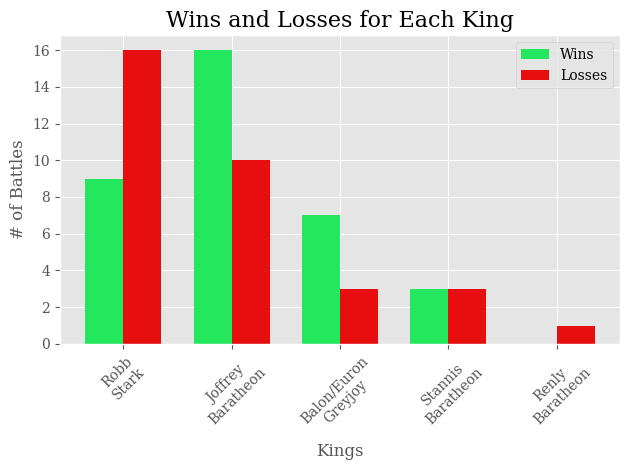

In [682]:
# Plot
bar_width = 0.35
index = range(len(kings))

win_color = '#23e85e'
lose_color = '#e60e0e'

plt.bar(index, df_kings['Wins'], bar_width, label='Wins', color=win_color)
plt.bar([i + bar_width for i in index], df_kings['Losses'], bar_width, label='Losses', color=lose_color)

plt.xlabel('Kings')
plt.ylabel('# of Battles')
plt.title('Wins and Losses for Each King', fontsize=16,)
plt.xticks([i + bar_width / 2 for i in index], [king.replace(" ", "\n") for king in kings], rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

It is clear that Robb Stark and Joffrey Baratheon are both winning and losing the most. 

The following plot shows the total number of battles where each house has had a major role. 



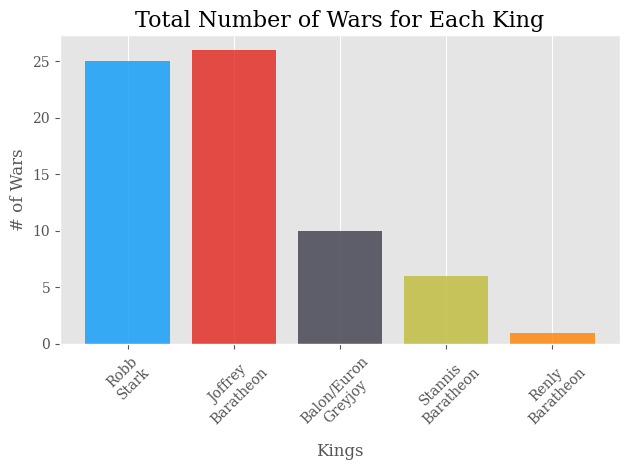

In [683]:
# Plot
plt.bar(df_kings['King'].str.replace(" ", "\n"), df_kings['Battles_Total'], color=[king_colors[king] for king in df_kings['King']], alpha=0.8)

plt.xlabel('Kings')
plt.ylabel('# of Wars')
plt.title('Total Number of Wars for Each King', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

The plot does not provide any further information that is not already given by the previous plot. <br>
The number of battles might not be interesting without the information of how many were lost/won. <br>
This leads us to investigate the winning rate of each house.

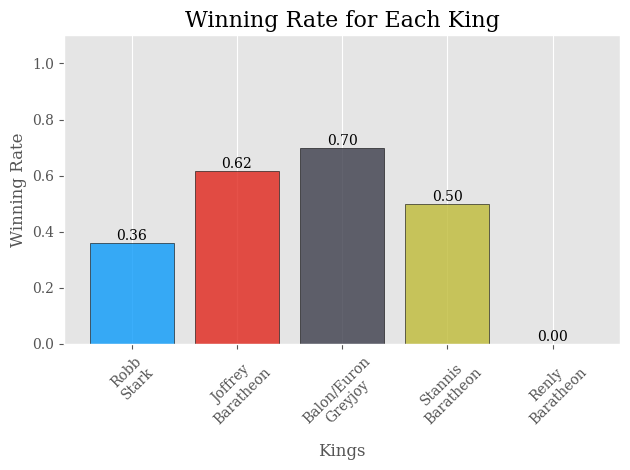

In [684]:
# Calculate winning rates
winning_rates = [df_kings['Wins'][i] / df_kings['Battles_Total'][i] for i in range(len(kings))]

# Plot
fig, ax = plt.subplots()
bars = ax.bar(kings, winning_rates, color=[king_colors[king] for king in kings], edgecolor='black', alpha=0.8)

plt.xlabel('Kings')
plt.ylabel('Winning Rate')
plt.title('Winning Rate for Each King', fontsize=16)
plt.xticks(kings, [king.replace(" ", "\n") for king in kings], rotation=45)
plt.ylim(0, 1.1)  # Set y-axis limit from 0 to 1 for percentage
plt.grid(axis='y')

# Add values on top of the bars
for bar, rate in zip(bars, winning_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.2f}'.format(rate), ha='center', va='bottom')

plt.tight_layout()
plt.show()

It can be seen that actually Balon/Euron Greyjoy has the highest winning rate. But one must remember that they does not fight as much as Robb Stark and Joffrey Baratheon.

# Data Analysis

We have now considered some of the basic statistics of the battle dataset, but by themselves, they don't carry a lot of information. In the following plot, we show similar statistics, but now we consider the interaction between the kings as well

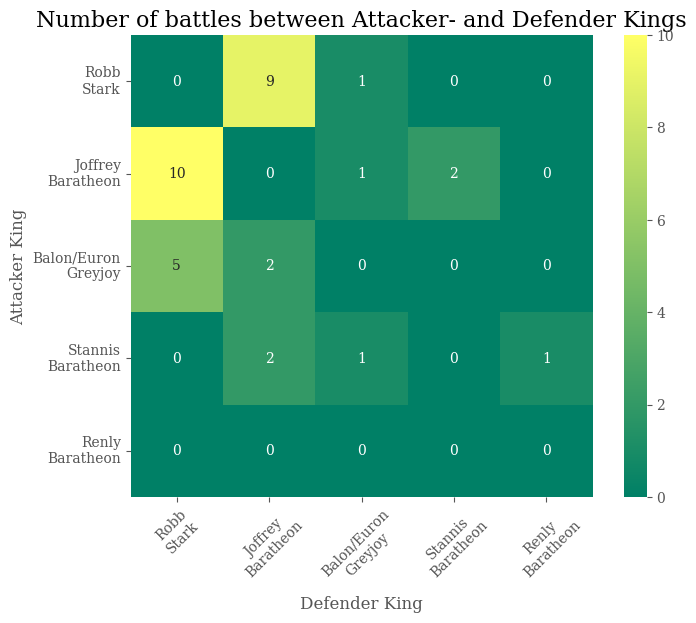

In [685]:
df_battle_5_kings = df_battle[(df_battle['attacker_king'] != 'Mance Rayder') & (df_battle['defender_king'] != 'Mance Rayder')]
pivot_table = df_battle_5_kings.pivot_table(index='attacker_king', columns='defender_king', aggfunc='size', fill_value=0)
pivot_table = pivot_table.reindex(index=kings, columns=kings, fill_value=0)

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(pivot_table, annot=True, cmap='summer', fmt='d', cbar=True, square=True)
heatmap.set_xticklabels([king.replace(" ", "\n") for king in kings], rotation=45)
heatmap.set_yticklabels([king.replace(" ", "\n") for king in kings], rotation=0)

plt.title('Number of battles between Attacker- and Defender Kings', fontsize=16)
plt.xlabel('Defender King')
plt.ylabel('Attacker King')
plt.show()

We end up using the following grid plot here instead of the one above. It not only shows how many times one has attacked another, but also their successrate as well. This essentially shows the same as before, but with the added benefit of getting the win-rates as well. We basically manage to add more information to our plot, without cluttering it to much.

In [686]:
df_battle_5_kings['win'] = df_battle_5_kings['attacker_outcome'].apply(lambda x: 1 if x == 'win' else 0)

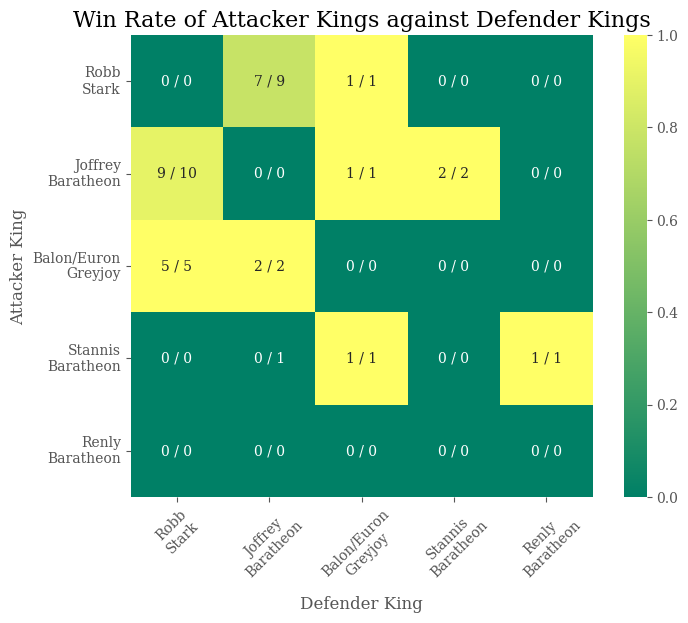

In [687]:
# Calculate total battles for each combination of attacker king and defender king
total_battles_df = df_battle_5_kings.pivot_table(index='attacker_king', columns='defender_king', values='attacker_outcome', aggfunc='count')
total_battles_df = total_battles_df.reindex(index=kings, columns=kings, fill_value=0)

# Calculate total wins for each combination of attacker king and defender king
total_wins_df = df_battle_5_kings.pivot_table(index='attacker_king', columns='defender_king', values='win', aggfunc='sum')
total_wins_df = total_wins_df.reindex(index=kings, columns=kings, fill_value=0)


# Calculate win rate by dividing total wins by total battles
win_rate_df = total_wins_df / total_battles_df

# Create a DataFrame to hold annotation values
total_wins_df.fillna(0, inplace=True)
total_battles_df.fillna(0, inplace=True)
win_rate_df.fillna(0, inplace=True)
annotations = total_wins_df.astype(int).astype(str) + ' / ' + total_battles_df.astype(int).astype(str)

# Plot the win rate heatmap with annotations
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(win_rate_df, annot=annotations, cmap='summer', fmt='', cbar=True, square=True)
heatmap.set_xticklabels([king.replace(" ", "\n") for king in kings], rotation=45)
heatmap.set_yticklabels([king.replace(" ", "\n") for king in kings], rotation=0)
plt.title('Win Rate of Attacker Kings against Defender Kings', fontsize=16)
plt.xlabel('Defender King')
plt.ylabel('Attacker King')
plt.show()

In this plot, we show the distribution of battle types among kings. This could easily have been made into 4 separate plots; one for each battle type, or king. Instead we manage to show all battle types for each king, while still managing to keep these “clusters” separated. It gives a good overview of the relation between kings, as well as the distribution of one battle type compared to the other types.

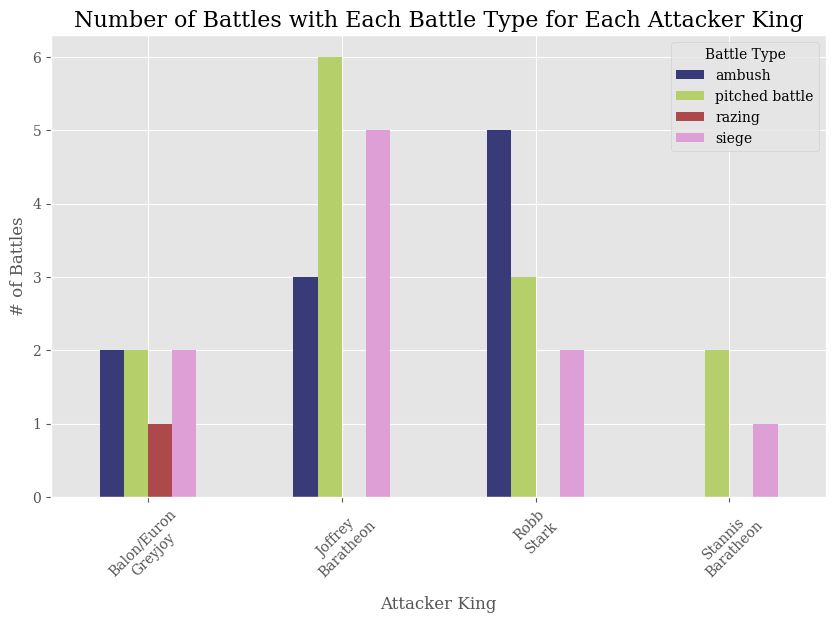

In [688]:
# Create a pivot table to count the number of battles of each type for each attacker king
df_battle_type = df_battle_5_kings.pivot_table(index='attacker_king', columns='battle_type', aggfunc='size', fill_value=0)
ax = df_battle_type.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='tab20b', rot=45) 

# Add labels and title
ax.set_xlabel('Attacker King')
ax.set_ylabel('# of Battles')
ax.set_title('Number of Battles with Each Battle Type for Each Attacker King', fontsize=16)
ax.legend(title='Battle Type')
ax.set_xticklabels(["Balon/Euron\nGreyjoy", "Joffrey\nBaratheon", "Robb\nStark", "Stannis\nBaratheon"])

plt.show()

In [689]:
maps = [
    "got_locations.geojson",
    "got_continents.geojson",
    "got_islands.geojson",
    "got_lakes.geojson",
    "got_landscape.geojson",
    "got_officialMapAreas.geojson",
    "got_political.geojson",
    "got_regions.geojson",
    "got_rivers.geojson",
    "got_roads.geojson",
    "got_wall.geojson"
]
folder = "GoTRelease/"
all_data = []
for map in maps:
    gdf = gpd.read_file(folder + map)
    all_data.append(gdf)

df_map = all_data[0].dropna(subset='name')
df_continent = all_data[1].dropna(subset='name')
df_island = all_data[2].dropna(subset='name')
df_political = all_data[6].dropna(subset='name')
df_political['area'] = df_political['geometry'].area

df_region = all_data[7].dropna(subset='name')
df_river = all_data[8].dropna(subset='name')
df_road = all_data[9].dropna(subset='name')
df_wall = all_data[10].dropna(subset='name')


To concatenate the battle data with the map data, we require that they both include a common key. In this case, the “location” works for this case. But since the datasets have different origin, there are multiple cases of differing naming convention of locations. Since we can’t directly connect the datasets by location name, we have to manually link one location with the other. In some cases, the locations are not even called the same, even if they represent the same place (approximately). This is because some of these informations have to be interpreted from the book/series. In this case, we have had to search the internet for locations in the Game of Thrones universe, to find the best match. 

This approach might include some bias, but that really can’t be prevented. If we only kept the parts where both datasets matched on location name, we would only have ⅔ of the battle locations in the end. This severely hurts the story telling.


In [690]:
# Lower case locations
df_map['name'] = df_map['name'].str.lower()
battle_names = df_battle['location'].str.lower().tolist()

In [691]:
# load json file
battle_location = json.load(open('battle_location.json'))
location_ids = list(battle_location.values())
location_ids = [x for x in location_ids if x != -1]
df_locations = df_map[df_map['id'].isin(location_ids)]
N = 500

In [692]:
# Add Islands
df_island['name'] = df_island['name'].str.lower()

c0 = df_island[df_island['name'].str.contains('arbor')]['geometry'].centroid
c1 = df_island[df_island['name'].str.contains('shield')]['geometry'].centroid

df_locations.loc[N] = [999, "the arbor", 3, 1, "Island", c0.values[0]]
N += 1
df_locations.loc[N] = [1000, "shield islands", 3, 1, "Island", c1.values[0]]
N += 1


# Add Rivers
df_river['name'] = df_river['name'].str.lower()
c2 = df_river[df_river['name'].str.contains('fork')]['geometry'].centroid
crs = c2.crs
df_locations.loc[N] = [1001, "green fork", 1, 1, "River", c2.values[0]]
N += 1
df_locations.loc[N] = [1002, "red fork", 1, 1, "River", c2.values[3]]
N += 1


# Add regions
df_region['name'] = df_region['name'].str.lower()
c3 = df_region[df_region['name'].str.contains('ston')]['geometry'].centroid
c4 = df_region[df_region['name'].str.contains('whispering wo')]['geometry'].centroid
df_locations.loc[N] = [1003, "stony shore", 1, 1, "Region", c3.values[0]]
N += 1
df_locations.loc[N] = [1004, "whispering wood", 1, 1, "Region", c4.values[0]]
N += 1


# Add locations
df_locations.loc[121,'name'] = "Crag"
df_locations.loc[32,'name'] = "Raventree"
df_locations.loc[36,'name'] = "Ruby ford"
df_locations.loc[500,'name'] = "Ryamsport, vinetown, starfish harbor"

In [693]:
# capitalize df_locations['name']
df_locations['name'] = df_locations['name'].str.capitalize()
df_battle['location'] = df_battle['location'].str.capitalize()

In [694]:
big_locations = pd.merge(df_battle[['battle_number','attacker_king','defender_king','attacker_1', 'defender_1','victor','location','region']], 
                         df_locations[['id','name','geometry']], left_on='location', right_on='name', how='right').sort_values('battle_number')
big_locations['defender_1'].fillna('Neutral', inplace=True)

In [695]:
battle_names = df_battle[['name','battle_number']]
battle_names.columns = ['battle_name','battle_number']
big_locations = pd.merge(big_locations, battle_names, on='battle_number')

In [696]:
# df_locations.geometry.crs = crs
big_locations.geometry.crs = crs 

location_data = []
location_data.append(df_political)
location_data.append(df_road)
location_data.append(df_river)
location_data.append(big_locations)



There are many houses, and some of the names might even sound similar. This is why we utilize multiple colors to represent each house. In the series, the houses have banners of different colors, which have inspired the choice of colors in this analysis. It’s important that the larger houses are more distinguishable as not to confuse the reader, while the smaller houses can have arbitrary colors.

Later on, we group houses by their alliances to provide an easier overview of which battles are fought for which side. Providing every different attacker on the map plot with a different color would simply be interpreted a noise, if we did not group them together. They are currently grouped as “Stark” (Robb Stark), “Lannister” (Joffrey Baratheon), “Greyjoys” (Balon and Euron Greyjoy), and “Baratheon” (Stannis Baratheon).


In [697]:
# Define colors

house_color = {"Stark": 'grey',
                "Lannister": 'red',
                "Greyjoy": 'black',
                "Baratheon": 'yellow',
                "Tully" : 'blue',
                "Night's Watch": 'cyan',
                "Tyrell": 'green',
                "Arryn": '#a13bcc',
                "Targaryen": 'white',
                "Bolton" : 'pink',
                "Bracken": 'brown',
                "Frey": 'darkblue',
                "Darry" : 'lightblue',
                "Brave Companions": 'purple',
                "Free folk": 'lightgreen',
                "Mallister": 'magenta',
                "Blackwood": 'lime',
                "Martell": '#F28500',
                "Neutral": 'darkred'
                }

alliance_color = {
                "Stark": 'blue',
                "Blackwood": 'blue',
                "Tully" : 'blue',
                "Darry" : 'blue',
                "Lannister": 'red',
                "Frey": 'purple',
                "Tyrell": 'red',
                "Bolton" : 'red',
                "Bracken": 'red',
                "Greyjoy": 'black',
                "Baratheon": 'yellow',
                "Night's Watch": 'cyan',
                "Brave Companions": 'green',
                }

In [698]:
df_political['affiliation'] = ["Night's Watch", "Robb Stark", "Night's Watch", "Robb Stark", "The Greyjoys", "Martell", "Stannis Baratheon", "Arryn", "Joffrey Baratheon", "Joffrey Baratheon", "Joffrey Baratheon"]
df_political

,id,name,ClaimedBy,geometry,area,affiliation
0,1,New Gift,Night's Watch,"POLYGON ((15.03935 34.06690, 15.48995 34.03323...",6.262187,Night's Watch
1,2,Riverlands,Tully,"POLYGON ((17.46128 4.10724, 17.41715 4.13667, ...",61.865201,Robb Stark
3,4,Bran's Gift,Night's Watch,"POLYGON ((15.17952 34.26780, 15.19425 34.29216...",5.651728,Night's Watch
4,5,The North,Stark,"MULTIPOLYGON (((10.68420 31.52314, 10.55847 31...",235.187066,Robb Stark
5,6,The Iron Islands,Greyjoy,"MULTIPOLYGON (((8.19405 13.37613, 8.24993 13.3...",2.338814,The Greyjoys
6,7,Dorne,Martell,"MULTIPOLYGON (((10.07742 -9.37693, 9.84223 -9....",73.896961,Martell
7,8,Stormlands,Baratheon,"MULTIPOLYGON (((17.98872 -4.08209, 17.89233 -3...",45.394908,Stannis Baratheon
8,9,The Vale,Arryn,"MULTIPOLYGON (((19.00333 18.18529, 18.94046 18...",57.136214,Arryn
9,10,The Westerlands,Lannister,"MULTIPOLYGON (((11.96501 11.16816, 12.22549 10...",46.391116,Joffrey Baratheon
10,11,Crownsland,Targaryen,"MULTIPOLYGON (((24.62625 7.22933, 24.74499 7.2...",19.684267,Joffrey Baratheon


For the purpose of ranking the kings, it might be interesting to look at the area claimed by them. For this we use the details from the mapplot to calculate the areasizes.


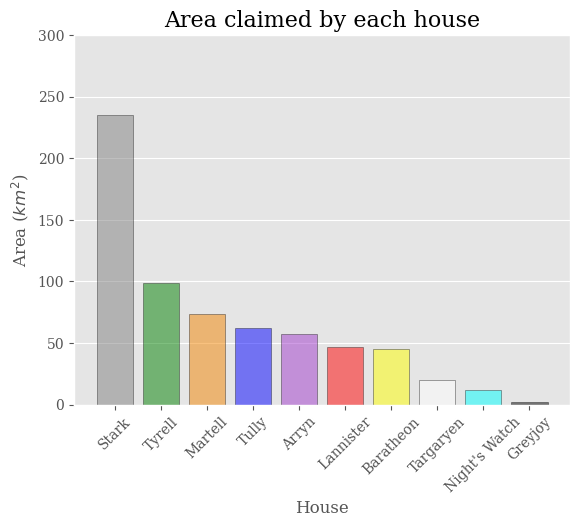

In [699]:
areas = df_political.groupby('ClaimedBy').sum('area').sort_values('area', ascending=False)
plt.bar(areas.index, areas['area'], color=[house_color[x] for x in areas.index], edgecolor='black', alpha=0.5)
plt.xticks(rotation=45, ha='center')
plt.title('Area claimed by each house', fontsize=16)
plt.ylabel('Area ($km^2$)')
plt.xlabel('House')
plt.grid(axis='x')
plt.ylim(0,300)
plt.show()

It is clear that Stark by far has claimed the most land. From the books we know that the North has a relatively low population density compared to other regions, partly due to its harsh climate and rugged terrain. This allows the ruling family, the Starks, to exert control over a larger area of land.

Since we have the members of alliances we want to see how the land-area distributes among them. 


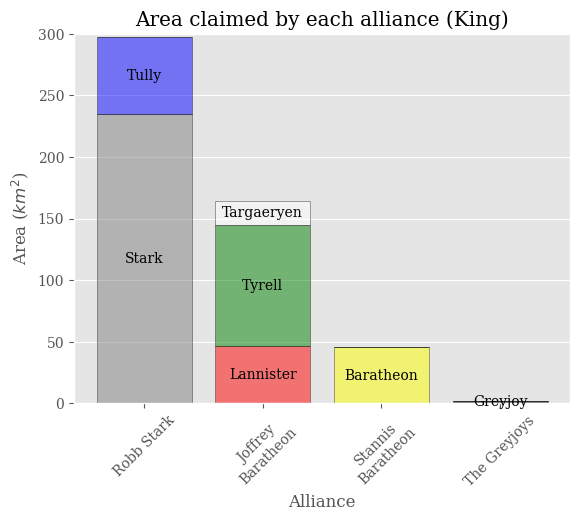

In [700]:
areas = df_political.groupby('ClaimedBy').sum('area').sort_values('area', ascending=False)
x = ["Robb Stark", "Joffrey\nBaratheon", "Stannis\nBaratheon","The Greyjoys"]
x1 = ["Stark", "Lannister", "Baratheon", "Greyjoy"]
y1 = [areas['area']['Stark'], areas['area']['Lannister'], areas['area']['Baratheon'], areas['area']['Greyjoy']]
plt.bar(x, y1, color=[house_color['Stark'], house_color['Lannister'], house_color['Baratheon'], house_color['Greyjoy']], edgecolor='black', alpha=0.5)

x2 = ["Tully", "Tyrell", "", ""]
y2 = [areas['area']['Tully'], areas['area']['Tyrell'], 0, 0]
plt.bar(x, y2, bottom=y1, color=[house_color['Tully'], house_color['Tyrell'], 'white', 'white'], edgecolor='black', alpha=0.5)

x3 = ["", "Targaeryen", "", ""]
y3 = [0, areas['area']['Targaryen'], 0, 0]
plt.bar(x, y3, bottom=[y1[i] + y2[i] for i in range(4)], color=['white', house_color['Targaryen'],  'white', 'white'], edgecolor='black', alpha=0.5)

# add text to each bar
for i in range(4):
    plt.text(i, y1[i]/2, f"{x1[i]}", ha='center', va='center', color='black', rotation=0)
    plt.text(i, y1[i] + y2[i]/2, f"{x2[i]}", ha='center', va='center', color='black', rotation=0)
    plt.text(i, y1[i] + y2[i] + y3[i]/2, f"{x3[i]}", ha='center', va='center', color='black', rotation=0)

plt.xticks(rotation=45, ha='center')
plt.title('Area claimed by each alliance (King)')
plt.ylabel('Area ($km^2$)')
plt.xlabel('Alliance')
plt.grid(axis='x')
plt.ylim(0, 300)
plt.show()

From the previous plot we saw that Robb Stark had (by far) claimed the most land - hence it makes sense that Stark and Tully together have the largest land-area. Surprisingly does Joffreys alliance: Lannister, Tyrell and Targaeryen have a large area of land when combined. 


This is the first of our map plots. It contains a lot of information about the battles and regions. The regions are shown by the color, from which house they are claimed by. Roads and rivers are shown as well. Hovering over any of these will provide a brief description. The markers indicate battles/rows from the dataset. As some battles happen in the same place, we have added some noise/jitter, so they are easily distinguishable. Hovering over a marker provides a tooltip that shows the names of the battle, the location, as well as the victorious house of the battle. The color of the marker is based on who won, and not who attacked. By clicking the marker, we then get this information. They include who attacked and defended (house and king), as well as the information from the tooltip (+ the index of the battle in the dataset). In the upper right corner, the reader can toggle the alliances they want to show. The “Stark” button therefore not only displays wins by the Stark house, but also others from this alliance.


In [701]:
m = folium.Map(location=[10,20], zoom_start=3, tiles=None)

fg = folium.FeatureGroup("All battles", control=False)
m.add_child(fg)

gT = folium.plugins.FeatureGroupSubGroup(fg, "Terrain", control=False)
m.add_child(gT)

g1 = folium.plugins.FeatureGroupSubGroup(fg, "Stark")
m.add_child(g1)

g2 = folium.plugins.FeatureGroupSubGroup(fg, "Lannister")
m.add_child(g2)

g3 = folium.plugins.FeatureGroupSubGroup(fg, "Greyjoy")
m.add_child(g3)

g4 = folium.plugins.FeatureGroupSubGroup(fg, "Baratheon")
m.add_child(g4)

gX = folium.plugins.FeatureGroupSubGroup(fg, "Others")
m.add_child(gX)

# Create jitter
np.random.seed(42)
jitter = np.random.rand(len(big_locations), 2)/2


# create a timeline with slider
features = []
index = 0
for i, row in big_locations.iterrows():
    
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['geometry'].x+jitter[index][0], row['geometry'].y+jitter[index][1]]
        },
        'properties': {
            'time' : str(format(2100+row['battle_number'],'02d'))+'-01-01',
            'tooltip': "<b style='color:black'>Battle:</b> " + row['battle_name'] + "<br>" + "<b style='color:black'>Location:</b> " + row['name'] + "<br>" + "<b style='color:green'>Victor:</b> " + row['victor'],
            'icon': 'circle',
            'iconstyle': {
                'color': alliance_color[row['victor']],
                'fillOpacity': 0.8,
                'stroke': 'false',
                'radius': 10
            },
            'popup': "<b style='color:black'>Battle ID:</b> " + str(row['battle_number']) + "<br>" +
                     "<b style='color:black'>Battle:</b> " + row['battle_name'] + "<br>" + 
                     "<b style='color:black'>Location:</b> " + row['name'] + "<br><br>" + 
                     "<b style='color:#d95d1a'>Attacker:</b> " + row['attacker_1'] + f" ({row['attacker_king']})" + "<br><br>" +
                     "<b style='color:#1a47d9'>Defender:</b> " + row['defender_1'] + f" ({row['defender_king']})"+ "<br><br>" +
                     "<b style='color:green'>Victor:</b> " + row['victor'],
        }
    }
    features.append(feature)
    index += 1


for i, data in enumerate(location_data):

    # Claimed regions    
    if i == 0:
        gj = folium.GeoJson(data=data, 
                        highlight_function=lambda x: {'fillColor': house_color[x['properties']['ClaimedBy']], 'color': 'orange', 'dashArray': '3, 6'},
                        style_function=    lambda y: {'opacity': 0.3, 'fillColor' : house_color[y['properties']['ClaimedBy']]},
                        tooltip=folium.GeoJsonTooltip(fields=['ClaimedBy', 'name'], aliases=['Claimed by', 'Region']))
        gj.add_to(gT)
        

    # Road        
    elif i == 1:
        gj = folium.GeoJson(data, 
                            style_function=lambda x: {'color' : 'gray', 'weight' : 2},
                            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Road']))
        gj.add_to(gT)
                
    # River        
    elif i == 2:
        data = data[(data['continent'] == 'Westeros') & (data['name'] != 'milkwater') & (data['name'] != 'antler')] 
        gj = folium.GeoJson(data, 
                            style_function=lambda x: {'color' : '#6cbcf5', 'weight' : 2},
                            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['River']))
        gj.add_to(gT)

    # Locations
    elif i == 3:
        index = 0
        for _, row in data.iterrows():
            marker = folium.Circle(
                location=[row['geometry'].y+jitter[index][1], row['geometry'].x+jitter[index][0]],

                popup = "<b style='color:black'>Battle ID:</b> " + str(row['battle_number']) + "<br>" +
                        "<b style='color:black'>Battle:</b> " + row['battle_name'] + "<br>" +
                        "<b style='color:black'>Location:</b> " + row['name'] + "<br><br>" + 
                        "<b style='color:#d95d1a'>Attacker:</b> " + row['attacker_1'] + f" ({row['attacker_king']})" + "<br><br>" +
                        "<b style='color:#1a47d9'>Defender:</b> " + row['defender_1'] + f" ({row['defender_king']})"+ "<br><br>" +
                        "<b style='color:green'>Victor:</b> " + row['victor'],
                
                radius=50000,
                opacity=0.8,
                fill_color=alliance_color[row['victor']],
                color=alliance_color[row['victor']],

                tooltip="<b style='color:black'>Battle:</b> " + row['battle_name'] + "<br>" + "<b style='color:black'>Location:</b> " + row['name'] + "<br>" + "<b style='color:green'>Victor:</b> " + row['victor']
            )
            if row['victor'] in  ["Stark", "Tully", "Darry", "Blackwood"]:
                marker.add_to(g1)
            elif row['victor'] in ["Lannister", "Tyrell", "Frey", "Bolton", "Bracken"]:
                marker.add_to(g2)
            elif row['victor'] == "Greyjoy":
                marker.add_to(g3)
            elif row['victor'] == "Baratheon":
                marker.add_to(g4)
            else:
                marker.add_to(gX)
                
            index += 1
            
folium.map.LayerControl(collapsed=False).add_to(m)

display(m)

In [702]:
# Save plot as html
# m.save('battles_static.html')

This plot is used in conjunction with the written timeline. It has similar features to the previous map plot, but it does not allow toggling. Instead, it shows the development of battles over time. This is supposed to provide a better understanding of why and when the battles have occurred. The time indicator in the bottom shows the battle index, instead of actual time, since our only time indicator is the year. The battles seem to be in chronological order, hence this is the time unit used in the plot.

In [703]:
m_time = folium.Map(location=[10,20], zoom_start=3, tiles=None)

# Create jitter
np.random.seed(42)
jitter = np.random.rand(len(big_locations), 2)/2


# create a timeline with slider
features = []
index = 0
for i, row in big_locations.iterrows():
    
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['geometry'].x+jitter[index][0], row['geometry'].y+jitter[index][1]]
        },
        'properties': {
            'time' : str(format(2100+row['battle_number'],'02d'))+'-01-01',
            'tooltip': "<b style='color:black'>Battle:</b> " + row['battle_name'] + "<br>" + "<b style='color:black'>Location:</b> " + row['name'] + "<br>" + "<b style='color:green'>Victor:</b> " + row['victor'],
            'icon': 'circle',
            'iconstyle': {
                'color': alliance_color[row['victor']],
                'fillOpacity': 0.8,
                'stroke': 'false',
                'radius': 10
            },
            'popup': "<b style='color:black'>Battle ID:</b> " + str(row['battle_number']) + "<br>" +
                     "<b style='color:black'>Battle:</b> " + row['battle_name'] + "<br>" + 
                     "<b style='color:black'>Location:</b> " + row['name'] + "<br><br>" + 
                     "<b style='color:#d95d1a'>Attacker:</b> " + row['attacker_1'] + f" ({row['attacker_king']})" + "<br><br>" +
                     "<b style='color:#1a47d9'>Defender:</b> " + row['defender_1'] + f" ({row['defender_king']})"+ "<br><br>" +
                     "<b style='color:green'>Victor:</b> " + row['victor'],
        }
    }
    features.append(feature)
    index += 1





for i, data in enumerate(location_data):

    # Claimed regions    
    if i == 0:        
        gj2 = folium.GeoJson(data=data, 
                        highlight_function=lambda x: {'fillColor': house_color[x['properties']['ClaimedBy']], 'color': 'orange', 'dashArray': '3, 6'},
                        style_function=    lambda y: {'opacity': 0.3, 'fillColor' : house_color[y['properties']['ClaimedBy']]},
                        tooltip=folium.GeoJsonTooltip(fields=['ClaimedBy', 'name'], aliases=['Claimed by', 'Region']))
        gj2.add_to(m_time)

    # Road        
    elif i == 1:
        gj2 = folium.GeoJson(data, 
                            style_function=lambda x: {'color' : 'gray', 'weight' : 2},
                            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Road']))
        gj2.add_to(m_time)
        
    # River        
    elif i == 2:
        data = data[(data['continent'] == 'Westeros') & (data['name'] != 'milkwater') & (data['name'] != 'antler')]
        gj2 = folium.GeoJson(data, 
                            style_function=lambda x: {'color' : '#6cbcf5', 'weight' : 2},
                            tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['River']))
        gj2.add_to(m_time)

    
# add the timeline
tsgj = plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features
}, 
duration='P38Y',
period='P1Y',
transition_time=500,
auto_play=True,
loop=True,
date_options='YY',
add_last_point=True)
tsgj.add_to(m_time)

display(m_time)

In [704]:
# Save plot as html
# m_time.save('battles_time.html')

# Genre

Choosing a magazine-style layout for our website was a decision rooted in storytelling. We wanted visitors to feel like they were flipping through the pages of a richly illustrated magazine, each section offering a new tale or insight into the world of Westeros using illustration and interactive plots.

Just like the series itself, a magazine format allows us to present a variety of content types in an engaging and cohesive way. By incorporating striking visuals from the dataset we aim to transport fans deeper into the world they love.

Additionally, the structured nature of a magazine layout helps us organize our content effectively, making it easy for visitors to navigate between different sections and find the sections that interest them most. The website is mainly author-driven due to the goal of storytelling, but tries to balance the story with reader-driven elements, like interactive map plots for readers to explore.

In essence, the magazine-style design of our website is a storytelling tool in itself, inviting visitors to immerse themselves in the epic saga of ice and fire.

## Applied tools from Visual Narrative

For **visual structuring** we stick with the *consistent visual platform*, as the layout of our website keeps the same shape and structure as the reader progresses. For **highlighting** we utilize *feature distinction* to differentiate between different groups. In our case, we can argue that the separation of regions (using geographical borders) is used for that. Regarding transition guidance, we barely use that. Most of our visualizations are 1 frame, with the exception of our animated map plot, which utilizes *animated transitions* in the form of an animated timeline of the battles on the map.


## Applied tools from Narrative Structure 

The **ordering** of the website is *linear*, since we stay true to the storytelling mode. The linear ordering allows us to determine when the reader get what information, hence making it easier for them to immerse themself.

The mapplots provide **interactivities** into the readers experience. These plots make it possible to *filter and select* the desired alliances. The plots add a *hover highlighting* (aka a “tooltip”) effect over the battles and regions, which provide the essencial details about the location, as well as who battled.. 
Beside the mapplot, the rest of the visualizations are static plots (*very limited interactivity*), to keep the reader focused on a specific narrative.

For **messaging** our goals, different techniques have been applied. A great story starts with an *introduction text* to catch the reader. Our website both includes an introduction to the practical information about the stats for the dataframe we use, and an introduction for the storytelling perspective. The first one mentioned is included for the sake of the assignment, but also so that the reader can be critical when it comes to our conclusion and discussion. The website are full of *Headlines* in GoT-themed font, to set the vibe and catch the readers eye.  *Annotations* explain the visualizations and help the reader understand the messages behind them. In the end, all the discussions and subconclusions are collected in a *summary*.



# Visualizations

The chosen visualizations all contribute to the website by simplifying information from the dataset. 
## Barplots
We distinguish between three types of barplot in our visualizations: Vertical, stacked and grouped barplot.

The *vertical barplot* illustrates the area claimed by each house. Given that we possess a single value for each house and aim to compare them in relation to one another, opting for a standard vertical bar plot is the most straightforward decision. This type of plot is both used when we compare the areas but also the winningrates.

An essential task for us was to compare the alliances while also visualizing which parties had the greatest involvement in each. While *stacked barplots* are not ideal for individual element comparison, they prove effective in analyzing the combined contributions of the houses.

*Grouped barplots* are great for comparing elements with multiple attributes, as we do in the ‘wins and losses’-plot or the battle-type plot. For each different attribute, the color must be unique, as it can provide an easy overview for the reader.


## Grid plot
To facilitate a detailed comparison between the kings, we employ a *grid plot*. In this visualization, the color within each grid cell is determined by the ratio of wins to the total number of battles fought between the combatants. This approach offers a comprehensive overview of each king's frequency of encounters and their corresponding success rates

## Diagram
A *diagram* was created to illustrate the alliances between the houses. This visualization summarizes the alliances that are documented in the battle data, as well as which king leads each alliance. For later use it also simplifies visualizations, as we can group houses together.


## Mapplots
This map works as an introduction to the geographical world of *Westeros*. It becomes more clear how and why some alliances exist, and gives more context into where battles occur. It lets the reader explore the map at their own pace. It even has the option to toggle the location markers of each alliance, to better grasp where certain groups have attacked.

Additionally, we later present an animated version of this plot, where we can see when battles have happened, in chronological order. To get most of this plot, it should be used in conjunction with the written timeline


# Discussion

Since Game of Thrones inherently is a story, it makes it easy for us to link the battle data to actual events. It essentially means that our data has a lot of *background*, despite being such a small dataset.

What has worked especially well is to combine the battle data with the map data. By tweaking some location names, we are able to plot battles on a map, which gives a much better overview and explanation of the story. For people who have already seen or read Game of Thrones, this might even induce a “aha”-moment, as we can now link events to a geographical overview

The dataset has some obvious flaws, namely that it is incomplete. This is primarily due to the fact, that neither the book nor tv-series share all details of every battle. Statistics such as army sizes and the name of certain defenders are forever kept a secret. Some values have also been typed in wrong, hence we have had to perform some manual alterations as pre-processing.

A challenge of working with this dataset is that we can’t really rely on raw numbers, like attacker/defender sizes or years, as these are very limited. Instead, the interactions between kings and houses carry most of the informations, which is why we had to be smart about displaying this information properly. 


# Contributions

## Website

| Section                        | s204122 | s204255 |
|--------------------------------|---------|---------|
| Preliminary                    |         |    X    |
| Introduction                   |    X    |         |
| Kings, Houses and Alliances    |    X    |         |
| The great battles of Westeros  |         |    X    |
| Timeline                       |    X    |         |
| Conclusion                     |         |    X    |
| Coding of website              |         |    X    |


## Explainer Notebook

| Section         | Marcus | Therese |
|-----------------|--------|---------|
| Motivation      |        |    X    |
| Basic stats     |        |    X    |
| Data analysis   |    X   |         |
| Genre           |        |    X    |
| Visualizations  |   X    |         |
| Discussion      |   X    |         |
